In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import glob
import pandas as pd
import numpy as np
import random
import seaborn as sns
import umap
from keras.models import load_model
from sklearn.decomposition import PCA
import pickle

from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

from ponyo import utils

from numpy.random import seed
randomState = 123
seed(randomState)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(os.path.join(base_dir,
                                           "config_human.tsv"))
params = utils.read_config(config_file)

In [3]:
# Load params
local_dir = params["local_dir"]
project_id = params['project_id']

In [4]:
# Load real template experiment
template_data_file = params['template_data_file']

# Load metadata file with grouping assignments for samples
metadata_file = os.path.join(
    base_dir,
    "data",
    "metadata",
    project_id+"_groups.tsv")

In [5]:
# Read data
template_data = pd.read_csv(
    template_data_file,
    header=0,
    sep='\t',
    index_col=0)

template_data.head()

,AFM,KIF15,CYSLTR2,LINC01482,FKBP10,CD1A,EFR3A,AP2S1,GORASP2,LINC00939,...,ZPLD1,DLG5,ADPRM,HEXIM1,RPS6KB1,EIF5A2,THNSL2,EIF2D,ZNF605,MET
SRR493937,0.00000,0.15519,2.06033,0.06556,12.10311,1.13939,9.55883,20.71610,11.70178,0.07527,...,0.00571,3.90028,1.84190,11.43667,3.35006,0.51361,2.27994,3.57329,0.54372,9.82588
SRR493938,0.00000,0.15142,1.94189,0.09644,12.12421,1.24462,10.19392,21.36571,11.61132,0.03026,...,0.00577,3.96599,1.83724,11.75408,3.60983,0.54215,2.24052,3.72556,0.51403,9.83203
SRR493939,0.00000,0.62648,0.81073,0.19038,14.83202,4.46329,26.52973,16.38069,23.51534,0.36326,...,0.05107,8.78888,2.59729,10.19850,5.60758,0.47735,6.36116,5.75683,1.89982,60.35963
SRR493940,0.01594,0.58505,0.70978,0.17388,13.67800,4.51526,26.43119,15.84213,23.43058,0.51255,...,0.01935,8.66267,2.51035,10.41132,5.88676,0.47272,6.49324,5.63288,1.92941,60.60972
SRR493941,0.00000,0.09110,0.61780,0.04144,14.42908,0.59906,11.06400,19.18536,13.02231,0.01448,...,0.00000,6.93590,2.52196,9.99073,2.71520,0.52918,3.08529,5.13365,1.20774,14.48830


In [6]:
"""
# Try different partitions of the data
smRNA_samples = ["SRR493961",
                 "SRR493962",
                 "SRR493963",
                 "SRR493964",
                 "SRR493965",
                 "SRR493966",
                 "SRR493967",
                 "SRR493968",
                 "SRR493969",
                 "SRR493970",
                 "SRR493971",
                 "SRR493972"]
#template_data = template_data.loc[smRNA_samples]
template_data = template_data.drop(smRNA_samples)
print(template_data.shape)
template_data.head()"""

'\n# Try different partitions of the data\nsmRNA_samples = ["SRR493961",\n                 "SRR493962",\n                 "SRR493963",\n                 "SRR493964",\n                 "SRR493965",\n                 "SRR493966",\n                 "SRR493967",\n                 "SRR493968",\n                 "SRR493969",\n                 "SRR493970",\n                 "SRR493971",\n                 "SRR493972"]\n#template_data = template_data.loc[smRNA_samples]\ntemplate_data = template_data.drop(smRNA_samples)\nprint(template_data.shape)\ntemplate_data.head()'

In [7]:
# Read metadata
metadata = pd.read_csv(
    metadata_file,
    header=0,
    sep='\t',
    index_col=0)

metadata.head()

,source
Sample,
SRR493937,Normal
SRR493938,Normal
SRR493939,Tumor
SRR493940,Tumor
SRR493941,Normal


In [8]:
# PCA encode
pca = PCA(n_components=2)

model = pca.fit(template_data)
template_PCAencoded = model.transform(template_data)

template_PCAencoded_df = pd.DataFrame(data=template_PCAencoded ,
                                         index=template_data.index,
                                         columns=['1','2'])

In [9]:
# Add tumor/normal labels
template_data_labeled = pd.merge(template_PCAencoded_df, metadata, left_index=True, right_index=True)
template_data_labeled

,1,2,source
SRR493937,-767.659946,-703.769005,Normal
SRR493938,-772.376619,-706.609145,Normal
SRR493939,131.798770,-124.914753,Tumor
SRR493940,134.699795,-125.695189,Tumor
SRR493941,-5865.981377,-1327.393014,Normal
SRR493942,-5877.232675,-1334.506382,Normal
SRR493943,3818.332918,-1751.944632,Tumor
SRR493944,3820.906850,-1755.312821,Tumor
SRR493945,-3452.214591,-532.865473,Normal
SRR493946,-3446.609998,-530.805669,Normal


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


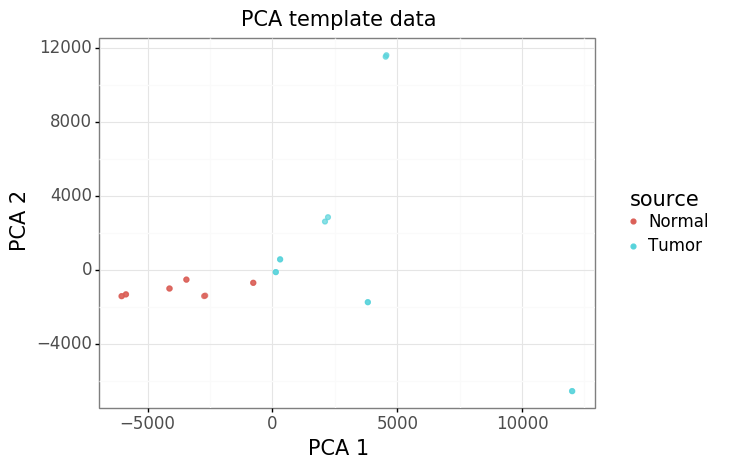

<ggplot: (8752396047345)>


In [10]:
# Plot
fig = ggplot(template_data_labeled, aes(x='1', y='2'))
#fig += ggplot(template_data_labeled[template_data_labeled['source']=='Normal'], aes(x='1', y='2'))
fig += geom_point(aes(color='source'), alpha=0.7)
fig += labs(x ='PCA 1',
            y = 'PCA 2',
            title = 'PCA template data')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))
#fig += ylim(-750000,10)
#fig += xlim(-1000000,-750000)

print(fig)